In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_core.messages import AIMessage
# decorater를 위함
from langchain_core.tools import tool 

# tool을 노드로 만들기 위한 라이브러리
from langgraph.prebuilt import ToolNode

#### **Langgraph Custom Tool 선언** ####

In [3]:
@tool
def get_weather(location: str):
    """Call to get the weather"""
    if location in ["서울", "인천"]:
        return "It's 60 degrees and foggy."
    else:
        return "It's 90 degrees and sunny."

In [4]:
@tool
def get_coolest_cities():
    """Get a list of coolest cities"""
    return "서울, 고성"

In [5]:
# tool node로 만들기.
tools = [get_weather, get_coolest_cities]
tool_node = ToolNode(tools)

In [6]:
# AI호출. - 어떤 도구들이 있는지 알기위한 bind_toolds
from langchain_openai import ChatOpenAI

model_with_tools = ChatOpenAI(
    model="gpt-4o-mini", temperature=0
).bind_tools(tools)

In [7]:
# 입력값으로 서울 지역을 줬기 때문에 args가 나온다.
model_with_tools.invoke("서울 날씨는어때?").tool_calls

[{'name': 'get_weather',
  'args': {'location': '서울'},
  'id': 'call_9zHGq17JhyYCJYAwv1J3X81r',
  'type': 'tool_call'}]

In [8]:
model_with_tools.invoke("대한민국의 대통령은 누구야?").tool_calls

[]

In [9]:
print(model_with_tools.invoke("서울 날씨는어때?"))

content='' additional_kwargs={'tool_calls': [{'id': 'call_PErCs3NRlt9P5be68iV9K2OW', 'function': {'arguments': '{"location":"서울"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 69, 'total_tokens': 83, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_1bb46167f9', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-5b40e152-f62a-409a-8990-641dea7680f7-0' tool_calls=[{'name': 'get_weather', 'args': {'location': '서울'}, 'id': 'call_PErCs3NRlt9P5be68iV9K2OW', 'type': 'tool_call'}] usage_metadata={'input_tokens': 69, 'output_tokens': 14, 'total_tokens': 83}


In [10]:
# 어떤 함수를 써야하는지는 알지만, 입력값이 없기 때문에 args가없다.
model_with_tools.invoke("한국에서 가장 추운 도시는?").tool_calls

[{'name': 'get_coolest_cities',
  'args': {},
  'id': 'call_75TjVN0leaErVb0JebTJGTeG',
  'type': 'tool_call'}]

In [11]:
tool_node.invoke({"messages": [model_with_tools.invoke("서울 날씨는 어때?")]})

{'messages': [ToolMessage(content="It's 60 degrees and foggy.", name='get_weather', tool_call_id='call_qhtydGnDJx3BUzSaBGqvKu5L')]}

#### **노드, 엣지를 선언하고 그래프 정의하기** ####

In [12]:
from typing import TypedDict, Annotated, Literal
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool
from langgraph.graph import END, START, StateGraph, MessagesState

# state로는: 메세지만 받는 MessagesState이며, 출력값은 tools나 END값이어야한다.
def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [13]:
# 유저의 입력 메세지를 입력해서 응답을 받는다.
# 메세지가 들어왔을때 tools가 있다는것을 인지하고 있는 모델에게, invoke함수로 해당 메세지를 입력해서 응답을 받는다.
def call_model(state: MessagesState):
    messages = state['messages']
    response = model_with_tools.invoke(messages) #은 llm을 bind_tools(tools)로 묶은 llm이다.
    return {"messages": [response]}

In [14]:
workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model) # 문장입력
workflow.add_node("tools", tool_node) #tools가 들어있는 tool_node

workflow.add_edge(START, "agent")

# 조건부 엣지
workflow.add_conditional_edges(
    "agent",
    should_continue
)

workflow.add_edge("tools", "agent") #tools node는 무조건 agent에게 응답을보내게 된다.

app = workflow.compile()

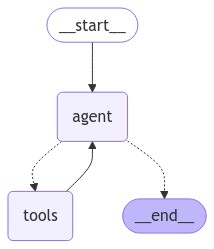

In [15]:
# 점선은 add_conditional_edges
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [17]:
final_state = app.invoke(
    {"messages": [HumanMessage(content="서울의 날씨는 어때?")]}
)
final_state["messages"][-1].content

'서울의 날씨는 60도(약 15도)이며 안개가 낀 상태입니다.'

In [18]:
# example with a multiple tool calls in succession

for chunk in app.stream(
    {"messages": [("human", "가장 추운 도시의 날씨는 어때?")]},
    stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

가장 추운 도시의 날씨는 어때?
================================== Ai Message ==================================
Tool Calls:
  get_coolest_cities (call_duxtyn4XCqaw0KmLXXXY9OJM)
 Call ID: call_duxtyn4XCqaw0KmLXXXY9OJM
  Args:
================================= Tool Message =================================
Name: get_coolest_cities

서울, 고성
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_4Q2kn5fycjtekWX9bIH5lXDr)
 Call ID: call_4Q2kn5fycjtekWX9bIH5lXDr
  Args:
    location: 서울
  get_weather (call_SrTvPGc6VKKFcaiUgxKUL7uO)
 Call ID: call_SrTvPGc6VKKFcaiUgxKUL7uO
  Args:
    location: 고성
================================= Tool Message =================================
Name: get_weather

It's 90 degrees and sunny.
================================== Ai Message ==================================

가장 추운 도시인 서울의 날씨는 60도(약 15도)로 안개가 끼어 있습니다. 반면, 고성의 날씨는 90도(약 32도)로 맑